# PiPCA Demo

PiPCA is a proof of concept Python tool used for exploratory data analysis on experimental LCLS data. This demo will review the functionality of the tool as it exists in its present state.

## Setup and Introductory Analysis

The functionality of PiPCA is accessible through the IPCA class in the btx repository. This tutorial assumes access to SLAC unix servers through the pslogin portal. First we add the relevant repository to our system path.

In [1]:
import sys
sys.path.append("/cds/home/h/hepworth/btx-callum")

Next we import all relevant functions from the ipca and psana_interface classes, as well as additional useful libraries.

In [2]:
from btx.interfaces.psana_interface import *
from btx.processing.ipca import *

import numpy as np

In order to run PiPCA on a dataset one must first initialize an instance of the IPCA class, supplying relevant parameters when necessary, including the run number, experiment name, and detector type of said data.

In [3]:
exp = 'amo06516' # experiment name
run = 90 #run number
det_type = 'pnccdFront' # detector name, e.g epix10k2M or jungfrau4M

q = 100 # number of principal components to compute and maintain
n = 500 # total number of images to be incorporated into model
m = 100 # size of image batch incorporated in each model update
start_offset = 0 # run index of first image to be incorporated into iPCA model

With a set of example parameters supplied we now instantiate our PiPCA instance.

In [4]:
ipca = IPCA(exp=exp, run=run, det_type=det_type, start_offset=start_offset, num_components=q, batch_size=m, num_images=n)

User supplied parameters are adjusted if they are incompatible with the PiPCA algorithm. The finalized parameters can be accessed as follows.

In [5]:
ipca.get_ipca_params()

(0, 100, 100, 1048576)

These values correspond to 
- the number of images incorporated thus far into the PiPCA model
- q, m, n

PiPCA is run on the user-specified dataset using the following method.

In [6]:
ipca.run_ipca()

WARNING! INVALID CALIBRATION FILE NAME "new" - missing dash
Factoring 100 samples into 0 sample, 100 component model...
Factoring 100 samples into 100 sample, 100 component model...
Factoring 100 samples into 200 sample, 100 component model...
Factoring 100 samples into 300 sample, 100 component model...
Factoring 100 samples into 400 sample, 100 component model...


Provided the sample run is small enough, metrics comparing a run of PiPCA and batch PCA on the supplied data can be computed using the `verify_model_accuracy` method


Verifying Model Accuracy
------------------------

q = 100
d = 1048576
n = 500
m = 100


Gathering images for batch PCA...
Performing batch PCA...


iPCA Normalized Compression Loss: 0.0015806516081571798
PCA Normalized Compression Loss: 0.0015799655350161688


iPCA Total Variance: 25525016.8040954
PCA Total Variance: 25525016.8040954


iPCA Explained Variance: 0.4194507222956616
PCA Explained Variance: 0.4200174825189827


iPCA Singular Values: 

[25372.66461923 23473.21214267 21419.96663224 20879.70505028
 18515.04836022 17164.47193671 10624.68703464 10479.78910362
 10249.56135697 10098.98895464  8753.08836025  8661.15921382
  8590.67775845  7948.59285001  7054.30642648  6796.24619242
  6142.19133196  6133.92246943  6063.69843248  6023.93492979
  5804.33752489  5785.79242863  5513.12188529  5372.96091176
  4892.21476724  4868.6049742   4835.24058399  4823.91417921
  4797.97031564  4778.7855197   4770.28231296  4744.62763837
  4729.04828983  4706.67126792  4659.73830534  4638.5178022

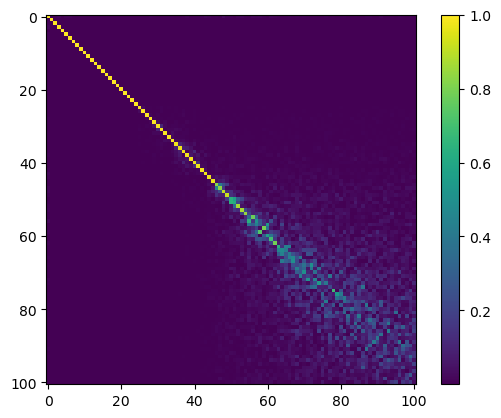





Mean per-batch compute time of step 'record pc data': 4.346s
Mean per-batch compute time of step 'update mean and variance': 1.066s
Mean per-batch compute time of step 'center data and compute augment vector': 2.283s
Mean per-batch compute time of step 'first matrix product U@S': 2.769s
Mean per-batch compute time of step 'QR concatenate': 1.114s
Mean per-batch compute time of step 'qr - local qr': 34.99s
Mean per-batch compute time of step 'qr - r_tot gather': 0.0002171s
Mean per-batch compute time of step 'qr - global qr': 0.003007s
Mean per-batch compute time of step 'qr - global svd': 0.01599s
Mean per-batch compute time of step 'qr - scatter q_tot': 0.0001082s
Mean per-batch compute time of step 'qr - local matrix build': 5.824s
Mean per-batch compute time of step 'qr - bcast S_tilde': 5.556e-05s
Mean per-batch compute time of step 'qr - bcast U_tilde': 5.215e-06s
Mean per-batch compute time of step 'parallel QR': 40.96s
Mean per-batch compute time of step 'compute local U_pri

In [7]:
ipca.verify_model_accuracy()

## CMD use and SLURM